In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import cartopy.crs as ccrs

from radiono import rm, utils as ut

%matplotlib inline 

`radionopy` is a natural next step from existing codes that calculate the RM for a given pointing on the sky for radio telescopes. Instead of a single pointing being printed to file, it holds all data in python arrays, which themselves are called from an IonoMap object.

The code's heritage is mainly from ionFR (http://sourceforge.net/projects/ionfr), which unfortunately includes bugs (e.g. RMs are always positive) and requires some inelegant string arguments. While radionopy is under active  development (most [all?] bugs found & removed), some of this heritage in terms of function arguments has not yet been superseded.

In this tutorial, I will give a flavour of different use cases for radionopy by manipulating the IonoMap object. It assumes one has executed `python setup.py develop` in the repo, which will compile the geomagnetic field model.

This tutorial actually generates Figure 5 in Moore et al 2017 at the end.

`#1`: Choose what day you want to get data for.

`#2`: State your latitude and longitude, since the B-field projection depends on your location. Note the funny way of stating negative values - the final character for this Southern-hemisphere site (the PAPER/HERA site, actually) is denoted with an "s" for south. Use "n" for north. Same for "e" and "w" for longitude. No minus-signs used. This will be simplified in later releases.

`#3`: Under the hood, `rm.IonoMap` is doing an anonymous ftp to the IONEX server to obtain TEC data for that night. For an overview of IONEX files, see `radionopy/docs/ionex_memo.pdf`. Unless specified in an argument to the call, the IONEX file will be placed in a directory named "TEC". If the file already exists, no ftp will occur.

In [2]:
YYYY,MM,DD = '2012','02','13' #1 

obsLat,obsLon = '30d43m17.5ss','21d25m41.9se' #2

IM = rm.IonoMap(obsLat,obsLon,['%s-%s-%s'%(YYYY, MM, DD)]) #3

# TEC and rms(TEC) are contained in the raw IONEX file as a spherical harmonic decomposition,
# making it a natural step to display as a full-sky map. ionh is the height of the ionosphere.
tec, rmstec, ionh = IM.ionex_data(YYYY, MM, DD)

print(tec.shape) # UT hours, npix
tecu = 0.1*tec # convert to TECU

(24, 3072)


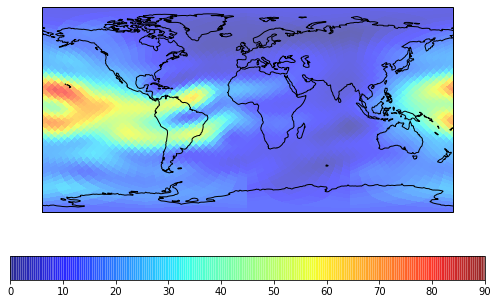

In [3]:
tecuUT=hp.cartview(tecu[0,:], fig=1, cmap="jet", flip="geo", min=0, max=90, return_projected_map=True) # get map for UT=0 hr

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
_tecu = ax.imshow(tecuUT, alpha=0.6, vmin=0, vmax=90, cmap="jet", extent=ax.get_extent())
plt.colorbar(_tecu, ax=ax, orientation="horizontal")
plt.show()

`radionopy` uses the International Geomagnetic Reference Field v11 (IGRF; Finlay et al. 2010), projecting it onto the IONEX TEC values and integrating, to calculate an RM for every ra,dec asked for. This can be a single (RA,Dec), the whole sphere, or anything inbetween. I'll show an example of each end:

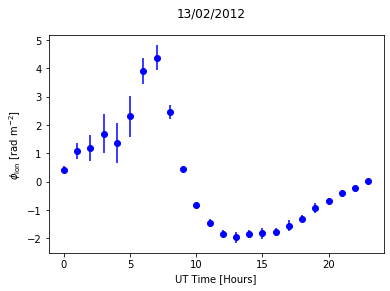

In [4]:
## SINGLE POINTING (Fornax A from PAPER/HERA site)

# approximate position of Fornax A (OK for an example method...). Note radians.
ra,dec = np.radians([50.67,-37.21]) 
IM.calc_radec_rm([ra],[dec])

# the IonoMap object will now contain arrays IM.RM, IM.dRM, and more. 
# They are len(ra) x UT hours shapes.
plt.errorbar(range(24), IM.RMs[0,:], yerr=IM.dRMs[0, :, 0], fmt='bo', ecolor='b')
plt.xlabel(r'UT Time [Hours]')
plt.ylabel(r'$\phi_{\rm ion}$ [rad m$^{-2}$]')
plt.suptitle(r'%s'%('/'.join([DD,MM,YYYY])))
plt.show()

In [5]:
## HEALPix GRID (all-sky RM from the PAPER/HERA site)

# simple generator function for ra, dec coords on a HealPix sphere
ras,decs = ut.nsideToRaDec(16) 

# NOTE: if we called this in the same cell as above before plotting,
# things would go wrong, since it will overwrite
# the arrays with new ones based on the argument supplied.
IM.calc_radec_rm(ras,decs)

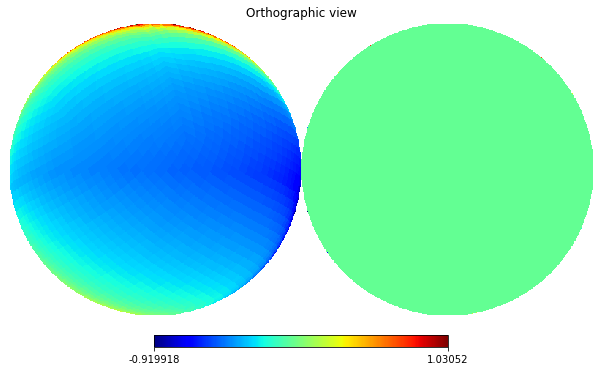

In [6]:
# To show 
mp = IM.RMs[0,0,:]
mp[np.where(IM.alt_src[0,0,:] < 0)]=0.
hp.orthview(mp, rot=[-IM.lst[0][0],30.712], cmap="jet")

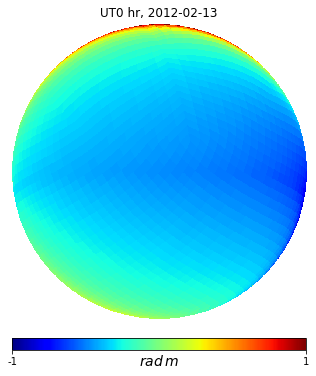

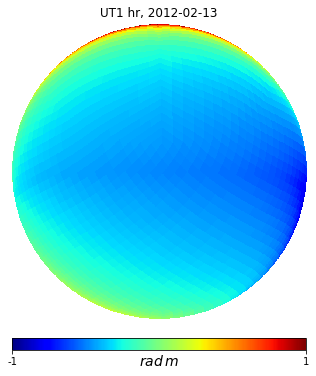

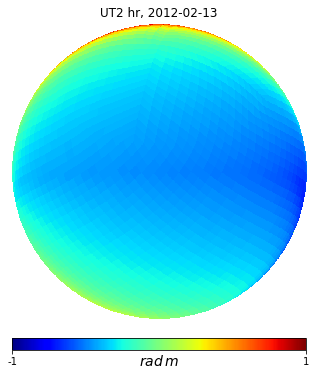

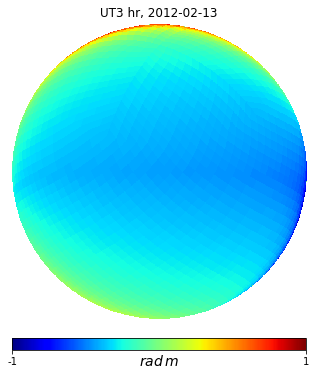

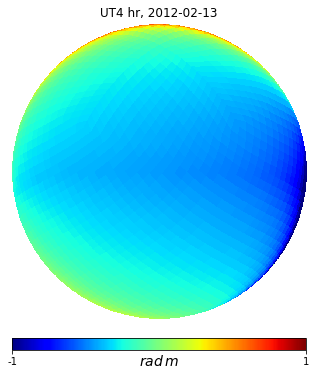

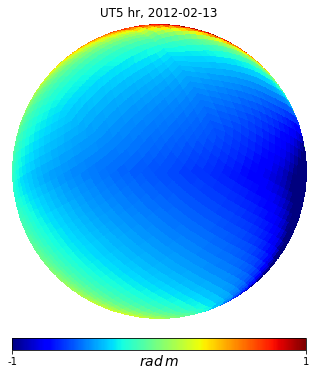

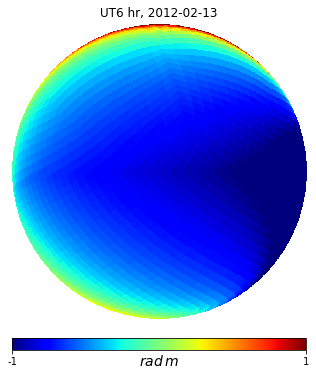

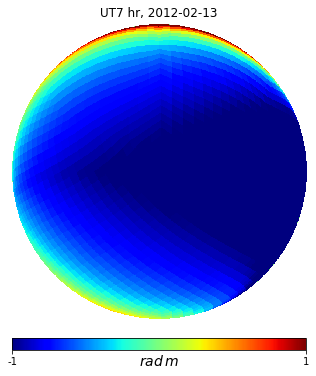

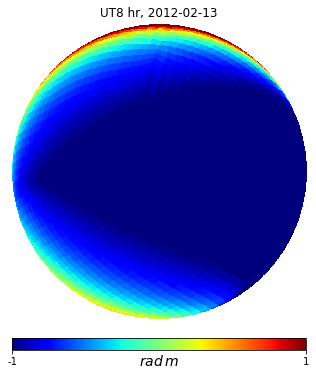

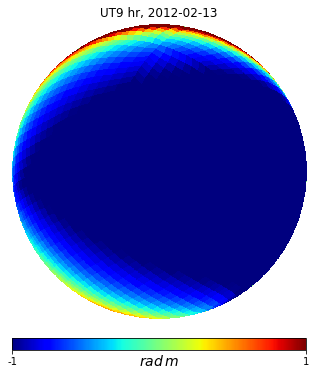

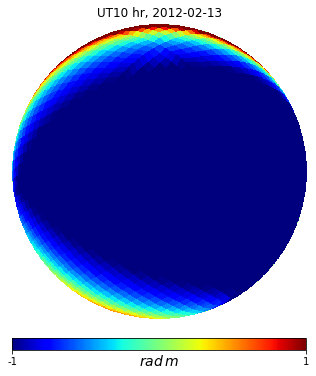

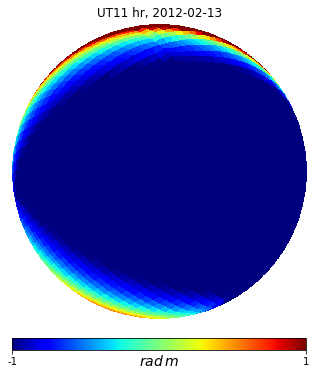

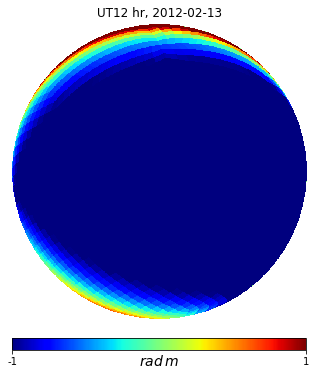

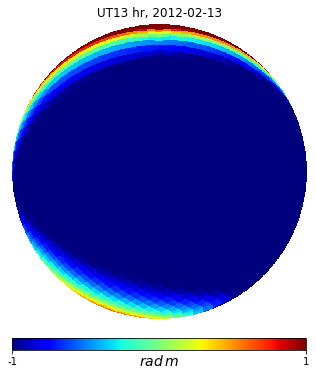

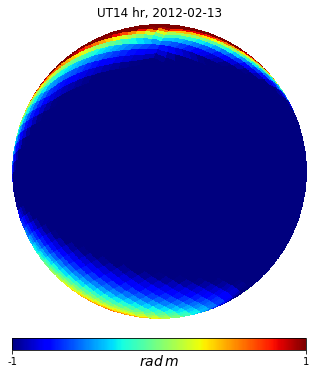

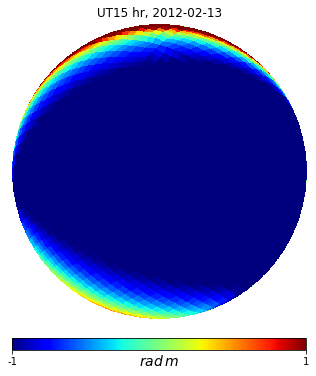

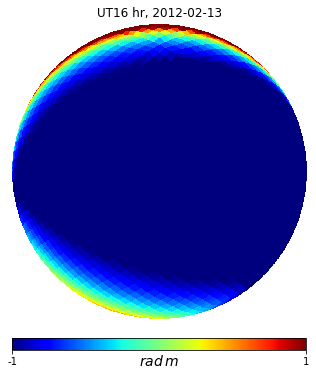

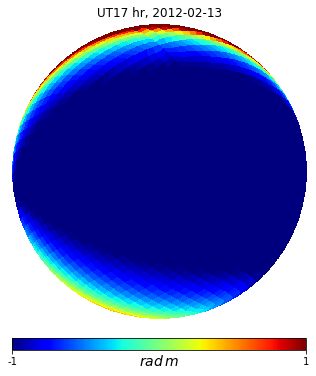

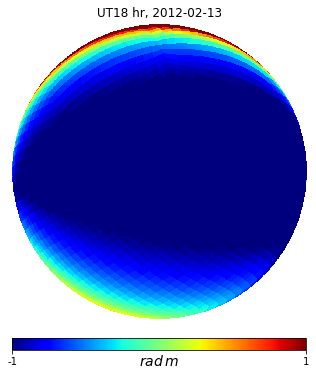

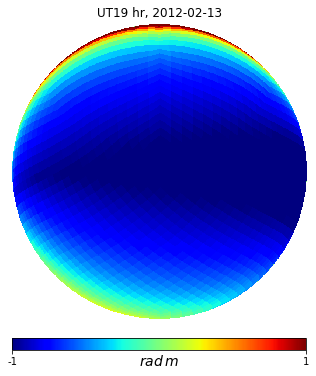

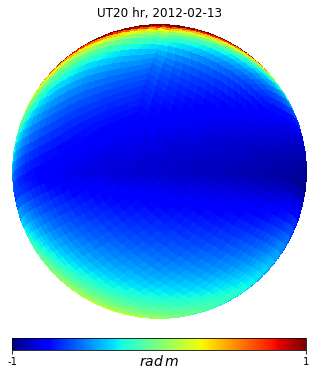

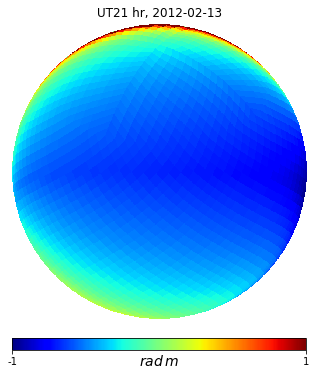

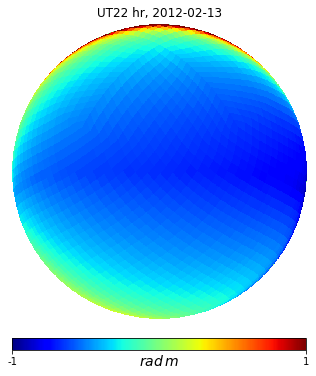

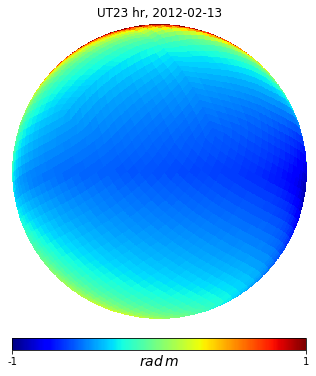

In [7]:
# This generates the pngs
for i,lst in enumerate(IM.lst[0]):
    mp = IM.RMs[0,i,:]
    mp[np.where(IM.alt_src[0,i,:] < 0)]=0.
    hp.orthview(mp, rot=[-lst,30.712], title='UT%i hr, 2012-02-13'%i, 
                min=-1, max=1, half_sky=True, unit=r'$rad\,m$',
                cmap="jet")
    plt.savefig('RM_map_UT'+str(i).zfill(2)+'.png')
    plt.show()
    plt.close()